# global_model-data_comparison

In [1]:
import warnings
warnings.simplefilter("ignore")
import statsmodels.api as sm
import statsmodels.tools.eval_measures as smte
import numpy as np
import pandas as pd
#
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mc
#
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
#
from netCDF4 import Dataset as NetCDFFile
from cdo import *
cdo =Cdo()

In [2]:
# 描画設定
plt.rcParams['figure.dpi'] = 300
plt.rcParams.update({'font.family': 'sans-serif', 'text.usetex': False,'pcolor.shading':'auto'})

In [3]:
# モニターする実験
exp_id="jra25.gndg"
# 比較する実験
# directories (環境依存)
gcmdir="."
# モニター図で平均する年数
intyrs=30

In [4]:
# 南極中心図で示す範囲
latmin=-90
latmax=-40
nlats=18 # 緯度方向のデータ数
lonmin=-180
lonmax=180
nlons = 128 # 経度方向のデータ数
c_df="black"
s_df=25
m_df="o"

In [5]:
# MIROC5-iso
ifile_hist_timmean_atm   = exp_id +"_miroc5-iso_last"+str(intyrs)+"yrs_timmean.iso.nc"
ifile_hist_yseasmean_atm = exp_id +"_miroc5-iso_last"+str(intyrs)+"yrs_yseasmean.iso.nc"
nc_hist_timmean_atm      = NetCDFFile(ifile_hist_timmean_atm)
nc_hist_yseasmean_atm    = NetCDFFile(ifile_hist_yseasmean_atm)

# Coordinates
lon_miroc = nc_hist_timmean_atm.variables["lon"]
lat_miroc = nc_hist_timmean_atm.variables["lat"]

# Time-mean values
d18Op_hist  = nc_hist_timmean_atm.variables["d18O_precip"][0,:,:]
temp2m_hist = nc_hist_timmean_atm.variables["tas"        ][0,:,:]
precip_hist = nc_hist_timmean_atm.variables["pr"         ][0,:,:]

# Multiyear seasonal mean values
d18Op_yseasmean_hist  = nc_hist_yseasmean_atm.variables["d18O_precip"][:,:,:]
temp2m_yseasmean_hist = nc_hist_yseasmean_atm.variables["tas"        ][:,:,:]
precip_yseasmean_hist = nc_hist_yseasmean_atm.variables["pr"         ][:,:,:]

# Time-mean values
d18Op_hist_cyc , lon_miroc_cyc = add_cyclic_point(d18Op_hist , coord=lon_miroc)
temp2m_hist_cyc, lon_miroc_cyc = add_cyclic_point(temp2m_hist, coord=lon_miroc)
precip_hist_cyc, lon_miroc_cyc = add_cyclic_point(precip_hist, coord=lon_miroc)

# Multiyear seasonal mean values
d18Op_yseasmean_hist_cyc , lon_miroc_cyc = add_cyclic_point(d18Op_yseasmean_hist , coord=lon_miroc)
temp2m_yseasmean_hist_cyc, lon_miroc_cyc = add_cyclic_point(temp2m_yseasmean_hist, coord=lon_miroc)
precip_yseasmean_hist_cyc, lon_miroc_cyc = add_cyclic_point(precip_yseasmean_hist, coord=lon_miroc)

In [6]:
ignip      = 'GNIP_world_2010_timemean_TPd18oD_12mon.csv'
iice       = 'IceCores_6k_PI.csv'
ispelothem = 'SISALv1b_d18O_carb_MH_anom_20190402.csv'
era40      = 'ERA40.1961.1990.t2m.stl1.stl4.timmean.nc'

# GNIP data
lat_gnip, lon_gnip, nyr_gnip, d18O_gnip, dD_gnip, prec_gnip, temp_gnip = np.genfromtxt(ignip, unpack=True, skip_header=1, delimiter=';', usecols = (1,2,4,6,7,8,9))
for i in range(len(lat_gnip)):
    if nyr_gnip[i] < 5:
        lat_gnip[i]  = np.nan
        lon_gnip[i]  = np.nan
        d18O_gnip[i] = np.nan 
        dD_gnip[i]   = np.nan
        prec_gnip[i] = np.nan 
        temp_gnip[i] = np.nan
dex_gnip = dD_gnip - 8.*d18O_gnip

# Ice core data
lat_ice, lon_ice, pd_tsurf_ice, pd_accu_ice, pd_d18O_ice, pd_dex_ice, delta_6k_pd_d18O_ice, delta_6k_pd_dex_ice = np.genfromtxt(iice, unpack=True, skip_header=1, delimiter=';', usecols = (1,2,3,4,5,6,7,8))

# Speleothems data
lat_speleo, lon_speleo, d18O_hist_pdb_speleo, d18O_6k_pdb_speleo, delta_6k_hist_d18O_pdb_speleo = np.genfromtxt(ispelothem, unpack=True, skip_header=1, delimiter=',', usecols = (1,2,5,6,7))

d18O_hist_csmow_speleo = (d18O_hist_pdb_speleo + 29.98) / 0.97002 #PDB to SMOW scale
temp_era40             = np.empty(len(lat_speleo))

for i in range(len(lat_speleo)):
    t             = cdo.selvar('stl1', input="-remapbil,lon="+np.str(lon_speleo[i])+"_lat="+np.str(lat_speleo[i])+" " + era40, options = "-f nc", returnArray  =  'stl1')
    temp_era40[i] = t[:,0,0]+273.15 # temperature needs to be in Kelvin
    
d18O_hist_vsmow_speleo = np.empty(len(lat_speleo))

for i in range(len(lat_speleo)):
    d18O_hist_vsmow_speleo[i] = d18O_hist_csmow_speleo[i] - ((16.1*1000.)/temp_era40[i] - 24.6) # Tremaine et al. 2011

In [7]:
d18Op_hist_scatter_data = np.concatenate( (d18O_gnip, pd_d18O_ice ) )
temp_hist_scatter_data  = np.concatenate( (temp_gnip, pd_tsurf_ice) )
idx_data0               = np.isfinite(temp_hist_scatter_data)

t                       = sm.add_constant(temp_hist_scatter_data[idx_data0], prepend=False)
model_t_d18Op_hist_data = sm.OLS(d18Op_hist_scatter_data[idx_data0],t)
r_t_d18Op_hist_data     = model_t_d18Op_hist_data.fit()
p_t_d18O_hist_data      = np.poly1d(r_t_d18Op_hist_data.params)
text_model_data         = "a = {:4.2f} ± {:4.3f}".format(r_t_d18Op_hist_data.params[0], r_t_d18Op_hist_data.bse[0]) + "\n$r^2$" + " = {:4.3f}".format(r_t_d18Op_hist_data.rsquared)

In [8]:
# gnip
idx                    = np.isfinite( lat_gnip)
d18O_hist_scatter_gnip = np.empty(len(lat_gnip))
temp_hist_scatter_gnip = np.empty(len(lat_gnip))

for i in range(len(lat_gnip)):
    if idx[i]==True:
        y2                        = cdo.selvar("d18O_precip", input="-remapbil,lon="+np.str(lon_gnip[i])+"_lat="+np.str(lat_gnip[i])+" " + ifile_hist_timmean_atm, options = "-f nc", returnArray  =  "d18O_precip")
        d18O_hist_scatter_gnip[i] = y2[:,0,0]
        y3                        = cdo.selvar("tas"        , input="-remapbil,lon="+np.str(lon_gnip[i])+"_lat="+np.str(lat_gnip[i])+" " + ifile_hist_timmean_atm, options = "-f nc", returnArray  =  "tas")
        temp_hist_scatter_gnip[i] = y3[:,0,0]
    else:
        d18O_hist_scatter_gnip[i] = np.nan
        temp_hist_scatter_gnip[i] = np.nan

# ice core
idx                   = np.isfinite( pd_d18O_ice)
d18O_hist_scatter_ice = np.empty(len(lat_ice))
temp_hist_scatter_ice = np.empty(len(lat_ice))

for i in range(len(lat_ice)):
    if idx[i]==True:
        y2                        = cdo.selvar("d18O_precip", input="-remapbil,lon="+np.str(lon_ice[i])+"_lat="+np.str(lat_ice[i])+" " + ifile_hist_timmean_atm, options = "-f nc", returnArray  =  "d18O_precip")
        d18O_hist_scatter_ice[i]  = y2[:,0,0]
        y3                        = cdo.selvar("tas"        , input="-remapbil,lon="+np.str(lon_ice[i])+"_lat="+np.str(lat_ice[i])+" " + ifile_hist_timmean_atm, options = "-f nc", returnArray  =  "tas")
        temp_hist_scatter_gnip[i] = y3[:,0,0]
    else:
        d18O_hist_scatter_ice[i]  = np.nan
        temp_hist_scatter_ice[i]  = np.nan
        
# speleothems
idx                      = np.isfinite( d18O_hist_vsmow_speleo)
d18O_hist_scatter_speleo = np.empty(len(lat_speleo))
temp_hist_scatter_speleo = np.empty(len(lat_speleo))

for i in range(len(lat_speleo)):
    if idx[i]==True:
        y2                          = cdo.selvar("d18O_precip", input="-remapbil,lon="+np.str(lon_speleo[i])+"_lat="+np.str(lat_speleo[i])+" " + ifile_hist_timmean_atm, options = "-f nc", returnArray  =  "d18O_precip")
        d18O_hist_scatter_speleo[i] = y2[:,0,0]
        y3                          = cdo.selvar("tas"        , input="-remapbil,lon="+np.str(lon_speleo[i])+"_lat="+np.str(lat_speleo[i])+" " + ifile_hist_timmean_atm, options = "-f nc", returnArray  =  "tas")
        temp_hist_scatter_gnip[i]   = y3[:,0,0]
    else:
        d18O_hist_scatter_speleo[i] = np.nan
        temp_hist_scatter_speleo[i] = np.nan
        
# concatenate
d18Op_hist_scatter_data2 = np.concatenate( (pd_d18O_ice          , d18O_hist_vsmow_speleo) )
d18Op_hist_scatter_model = np.concatenate( (d18O_hist_scatter_ice, d18O_hist_scatter_speleo) )

# Linear regression statistics
idx_data         = np.isfinite(    d18Op_hist_scatter_data2)
t                = sm.add_constant(d18Op_hist_scatter_data2[idx_data], prepend=False)
model_d18Op_hist = sm.OLS(         d18Op_hist_scatter_model[idx_data], t)
r_d18Op_hist     = model_d18Op_hist.fit()
RMSE_d18Op_hist  = smte.rmse(      d18Op_hist_scatter_data2[idx_data], d18Op_hist_scatter_model[idx_data])

text_d18Op_hist = "a = {:4.2f} ± {:4.3f}".format(r_d18Op_hist.params[0], r_d18Op_hist.bse[0]) + "\nRMSE = {:4.3f}".format(RMSE_d18Op_hist)

In [9]:
# Subplot: d18O-T hist
# gnip
idx                    = np.isfinite( lat_gnip)
temp_hist_scatter_gnip = np.empty(len(lat_gnip))

for i in range(len(lat_gnip)):
    if idx[i]==True:
        if temp_gnip[i] <= 20.:
            t                         = cdo.selvar("tas", input="-remapbil,lon="+np.str(lon_gnip[i])+"_lat="+np.str(lat_gnip[i])+" " + ifile_hist_timmean_atm, options = "-f nc", returnArray  =  "tas")
            temp_hist_scatter_gnip[i] = t[:,0,0]
        else:
            temp_hist_scatter_gnip[i] = np.nan
    else:
        temp_hist_scatter_gnip[i] = np.nan
        
# ice core
idx                   = np.isfinite( lat_ice)
temp_hist_scatter_ice = np.empty(len(lat_ice))

for i in range(len(lat_ice)):
    if idx[i]==True:
        t                        = cdo.selvar("tas", input="-remapbil,lon="+np.str(lon_ice[i])+"_lat="+np.str(lat_ice[i])+" " + ifile_hist_timmean_atm, options = "-f nc", returnArray  =  "tas")
        temp_hist_scatter_ice[i] = t[:,0,0]
    else:
        temp_hist_scatter_ice[i] = np.nan
        
# concatenate
d18Op_hist_scatter_model = np.concatenate( (d18O_hist_scatter_gnip, d18O_hist_scatter_ice))
temp_hist_scatter_model  =  np.concatenate((temp_hist_scatter_gnip, temp_hist_scatter_ice))

# Linear regresion statistics
idx_data2                = np.isfinite(    temp_hist_scatter_model)
t                        = sm.add_constant(temp_hist_scatter_model[idx_data2], prepend=False)
model_t_d18Op_hist_model = sm.OLS(        d18Op_hist_scatter_model[idx_data2],t)
r_t_d18Op_hist_model     = model_t_d18Op_hist_model.fit()
p_t_d18O_hist_model      = np.poly1d(r_t_d18Op_hist_model.params)

text_model_hist= "a = {:4.2f} ± {:4.3f}".format(r_t_d18Op_hist_model.params[0], r_t_d18Op_hist_model.bse[0]) + "\n$r^2$" + " = {:4.3f}".format(r_t_d18Op_hist_model.rsquared)

In [10]:
levels     = [-60, -50, -45, -40, -35, -30, -25, -20, -15, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0]
n_colors   = len(levels) + 1
cmap       = plt.get_cmap("RdBu_r", n_colors)
colors     = cmap(range(cmap.N))
cmap, norm = mc.from_levels_and_colors(levels, colors, extend="both")

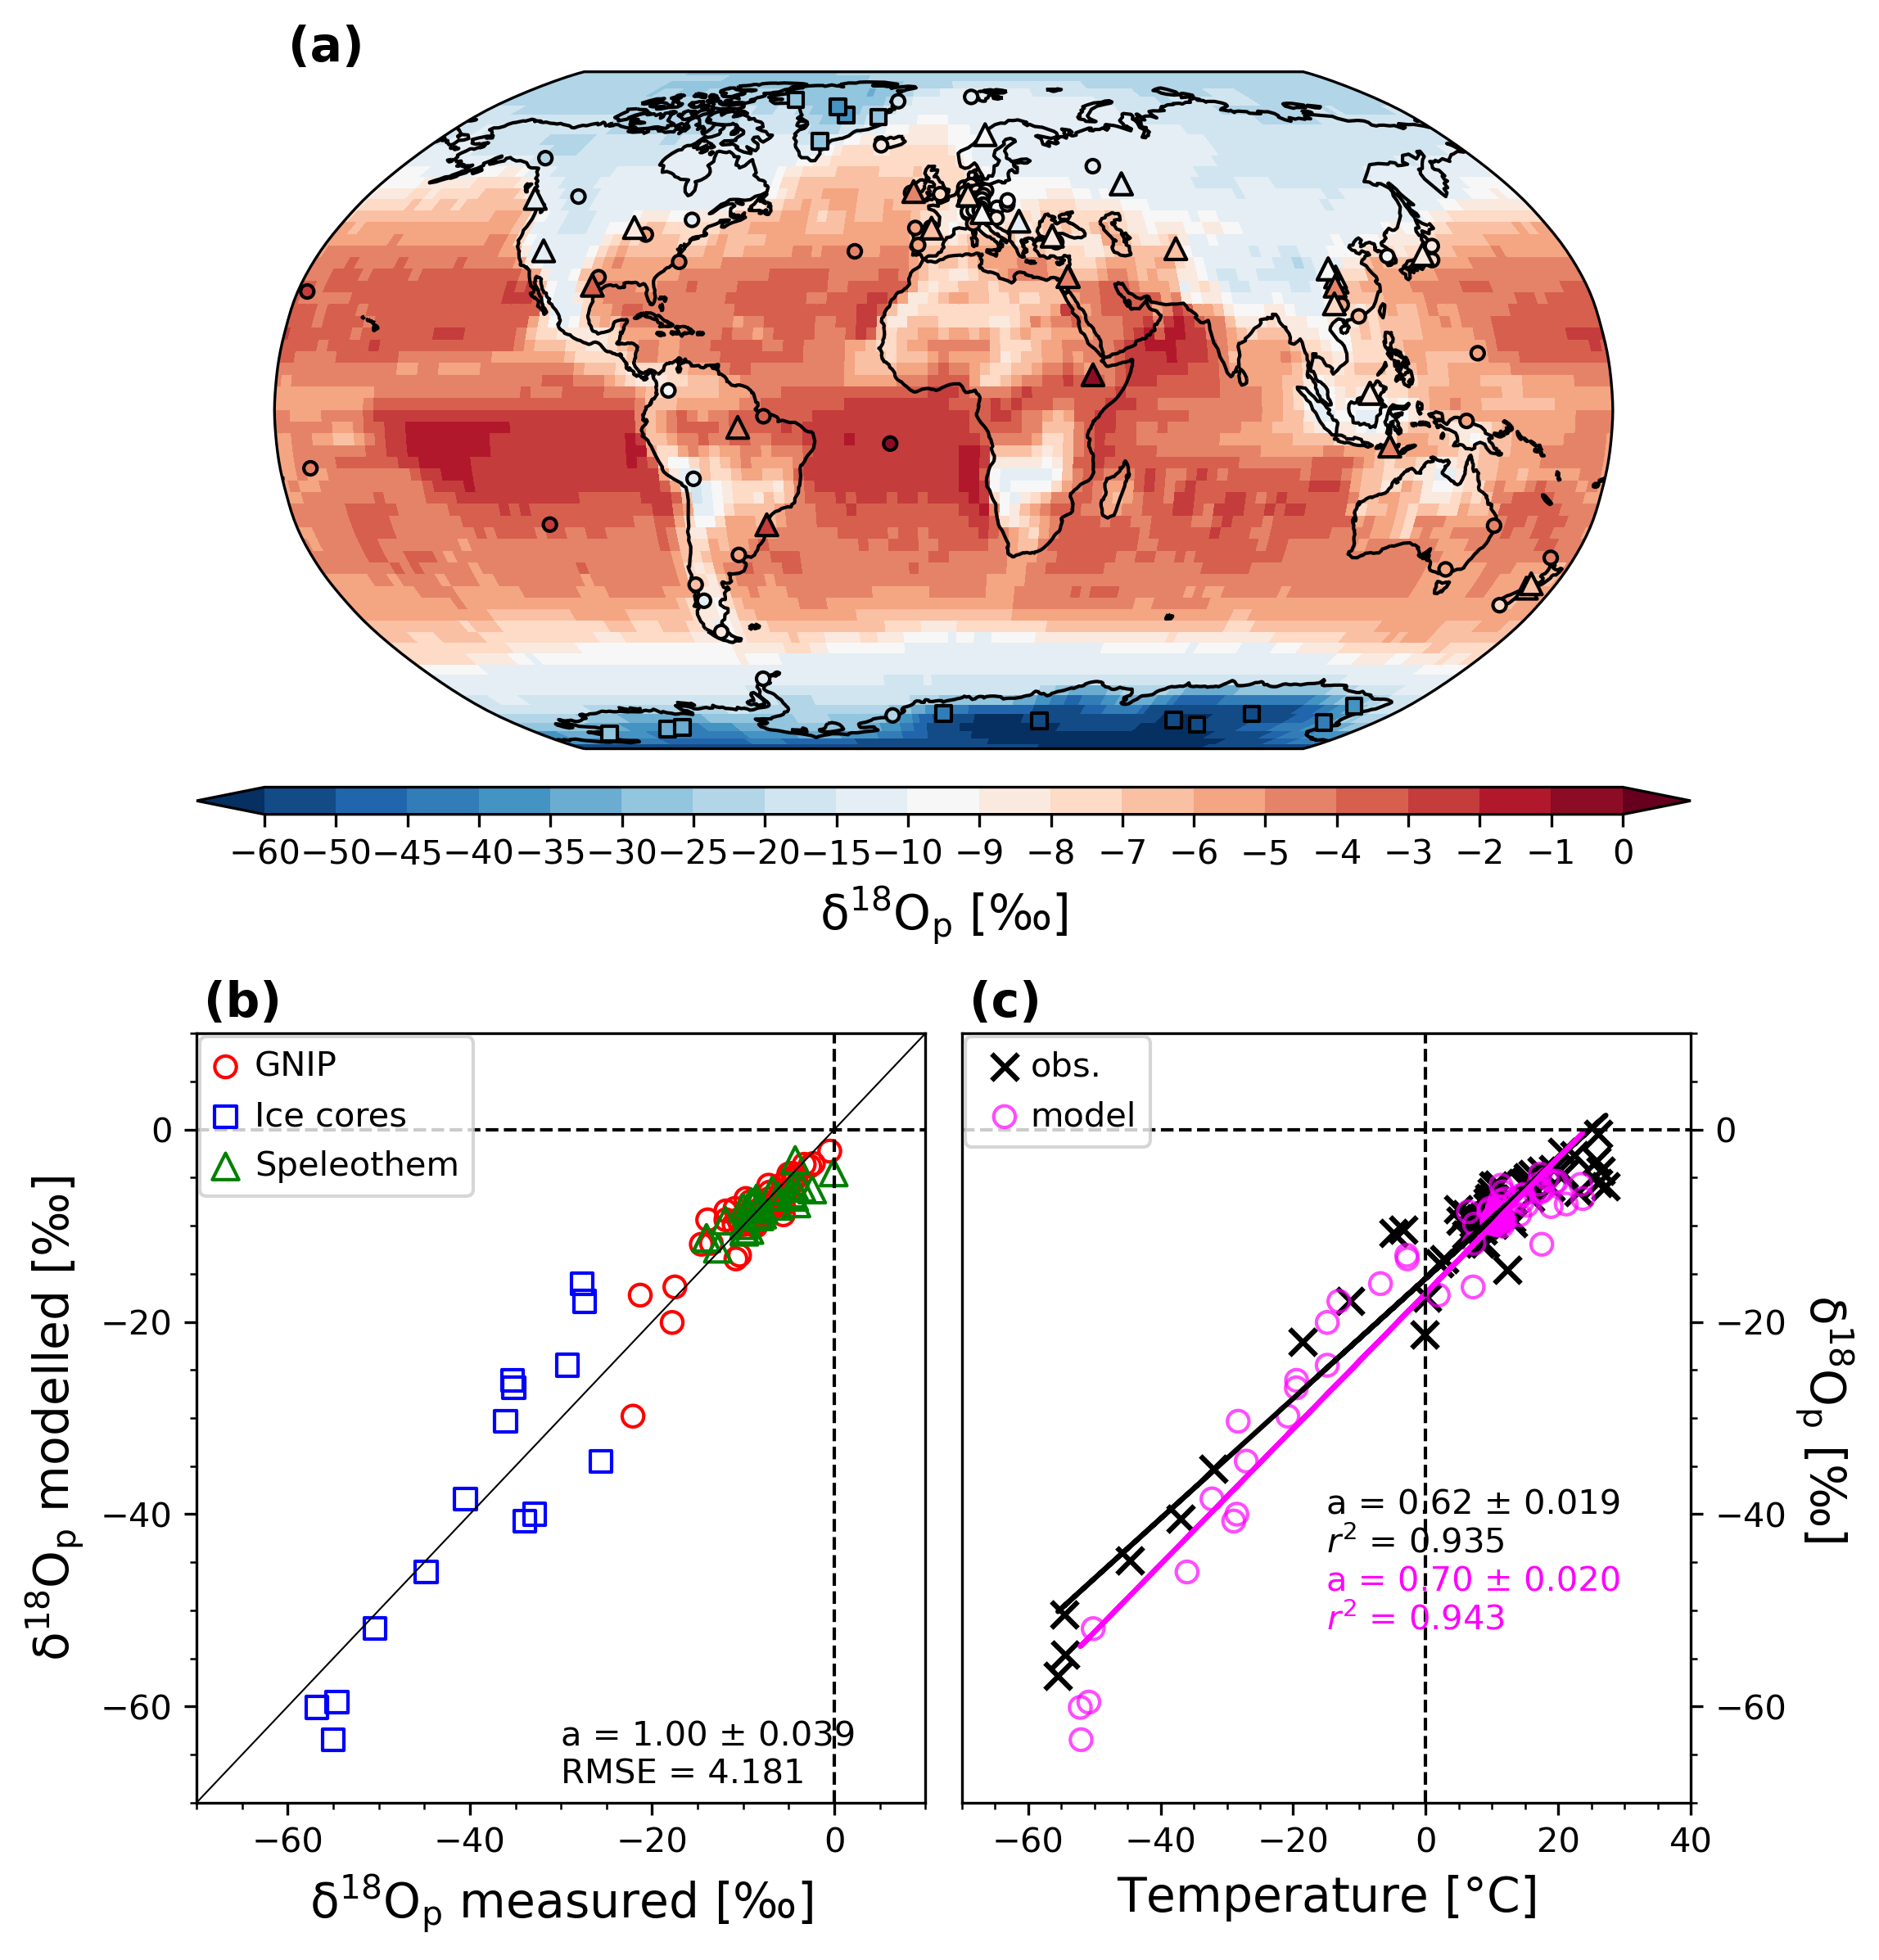

In [11]:
fig = plt.figure(figsize=(7.7,8.1))

ax1 = plt.subplot2grid((2,2), (0, 0), colspan=2, projection=ccrs.Robinson())

cs_world = ax1.pcolormesh(lon_miroc_cyc, lat_miroc, d18Op_hist_cyc, norm=norm, cmap=cmap, transform=ccrs.PlateCarree())
ax1.coastlines()
ax1.scatter(lon_gnip  , lat_gnip  , c=d18O_gnip             , s=15, cmap=cmap, marker="o", edgecolors="black", linewidth=1, norm=norm, zorder=3, transform=ccrs.PlateCarree())
ax1.scatter(lon_ice   , lat_ice   , c=pd_d18O_ice           , s=20, cmap=cmap, marker="s", edgecolors="black", linewidth=1, norm=norm, zorder=3, transform=ccrs.PlateCarree())
ax1.scatter(lon_speleo, lat_speleo, c=d18O_hist_vsmow_speleo, s=40, cmap=cmap, marker="^", edgecolors="black", linewidth=1, norm=norm, zorder=3, transform=ccrs.PlateCarree())

cbar = plt.colorbar(cs_world, orientation="horizontal", ticks=levels, pad=0.05, fraction=0.07, aspect=50)
cbar.ax.tick_params(labelsize=10)
cbar.set_label("$\mathsf{\delta^{18}O_{p}}$" + " [\u2030]", size=14)

plt.text(0.01,1.07, "(a)", horizontalalignment="left", verticalalignment="top", fontsize=14, weight="demibold", transform=ax1.transAxes)
# -----------------------------------------------------------------------------

ax2 = plt.subplot2grid((2,2), (1, 0))
plt.plot([-70,10], [-70,10], "black", linewidth=0.5)

l1 = plt.scatter(d18O_gnip             , d18O_hist_scatter_gnip  , s=40, facecolors="none", edgecolors="red"  , marker="o")
l2 = plt.scatter(pd_d18O_ice           , d18O_hist_scatter_ice   , s=40, facecolors="none", edgecolors="blue" , marker="s")
l3 = plt.scatter(d18O_hist_vsmow_speleo, d18O_hist_scatter_speleo, s=60, facecolors="none", edgecolors="green", marker="^")

plt.xlabel("$\mathsf{\delta^{18}O_p\ measured}$" + " [\u2030]", fontsize=14)
plt.ylabel("$\mathsf{\delta^{18}O_p\ modelled}$" + " [\u2030]", fontsize=14)
ax2.set_yticks(np.arange(-60,1,20))
ax2.set_yticks(np.arange(-70,15,5), minor=True)
ax2.set_xticks(np.arange(-60,1,20))
ax2.set_xticks(np.arange(-70,15,5), minor=True)
plt.xlim(-70,10)
plt.ylim(-70,10)

plt.legend([l1,l2,l3], ["GNIP","Ice cores","Speleothem"], loc="upper left",  ncol=1, fontsize=10, handletextpad=0.5, borderaxespad=0.1, borderpad=0.4, handlelength=0.7)

plt.axvline(x=0,ls="--",linewidth=1, color="black")
plt.axhline(y=0,ls="--",linewidth=1, color="black")

plt.text(0.5, 0.025, text_d18Op_hist, horizontalalignment="left", verticalalignment="baseline", fontsize=10, transform=ax2.transAxes)
plt.text(0.01,1.07, "(b)", horizontalalignment="left", verticalalignment="top", fontsize=14, weight="demibold", transform=ax2.transAxes)
#------------------------------------------------------------------------------

ax3 = plt.subplot2grid((2,2), (1, 1))
plt.plot(        temp_hist_scatter_data [idx_data0], p_t_d18O_hist_data( temp_hist_scatter_data [idx_data0]),                 "black")
l1 = plt.scatter(temp_hist_scatter_data [idx_data0], d18Op_hist_scatter_data [idx_data0], s=60,                             c="black"  , marker="x")
plt.plot(        temp_hist_scatter_model[idx_data2], p_t_d18O_hist_model(temp_hist_scatter_model[idx_data2]),                 "magenta")
l2 = plt.scatter(temp_hist_scatter_model[idx_data2], d18Op_hist_scatter_model[idx_data2], s=40, facecolors="none", edgecolors="magenta", marker="o",alpha=0.7)

plt.xlabel("$\mathsf{Temperature}$"    + " [\u00b0C]", fontsize=14)
plt.ylabel("$\mathsf{\delta^{18}O_p}$" + " [\u2030]" , fontsize=14, rotation=-90, labelpad=20)
ax3.set_yticks(np.arange(-60,1,20))
ax3.set_yticks(np.arange(-70,15,5), minor=True)
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")
ax3.set_xticks(np.arange(-60,45,20))
ax3.set_xticks(np.arange(-70,45,5), minor=True)
plt.xlim(-70,40)
plt.ylim(-70,10)

plt.axvline(x=0,ls="--",linewidth=1, color="k")
plt.axhline(y=0,ls="--",linewidth=1, color="k")

plt.legend([l1,l2], ["obs.","model"], loc="upper left", ncol=1, fontsize=10, handletextpad=0.01, columnspacing=0.1, borderaxespad=0.1, handlelength=1.5)

plt.text(0.5 , 0.325, text_model_data, horizontalalignment="left", verticalalignment="baseline", fontsize=10, color="black"    ,                    transform=ax3.transAxes)
plt.text(0.5 , 0.225, text_model_hist, horizontalalignment="left", verticalalignment="baseline", fontsize=10, color="magenta"  ,                    transform=ax3.transAxes)
plt.text(0.01, 1.07 , "(c)"          , horizontalalignment="left", verticalalignment="top"     , fontsize=14,                    weight="demibold", transform=ax3.transAxes)


plt.subplots_adjust(top=0.95, bottom=0.08, left=0.11, right=0.9, hspace=0.25, wspace=0.05)
plt.show()
fig.savefig("global_model-data_comparison.png")

Kanon Kino (kanon[at]aori.u-tokyo.ac.jp)